In [192]:
import d2l
import matplotlib.pyplot as plt
from mxnet import nd, autograd, gluon, init
from mxnet.gluon import nn
import pandas as pd
import numpy as np

In [193]:
train_df = pd.read_csv('./data/kaggle_house_pred_train.csv')
test_df = pd.read_csv('./data/kaggle_house_pred_test.csv')

In [194]:
print(train_df.shape)
train_df.describe()

(1460, 81)


,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [195]:
print(train_df.iloc[:4, [1, 2, 3]])

   MSSubClass MSZoning  LotFrontage
0          60       RL         65.0
1          20       RL         80.0
2          60       RL         68.0
3          70       RL         60.0


In [196]:
all_features = pd.concat((train_df.iloc[:, 1:-1], test_df.iloc[:, 1:]))
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(lambda x: (x-x.mean())/x.std())
all_features[numeric_features] = all_features[numeric_features].fillna(0)
all_features = pd.get_dummies(all_features, dummy_na=True)

In [197]:
n_train = train_df.shape[0]
train_features = nd.array(all_features[:n_train].values)
print(train_features.shape)
test_features = nd.array(all_features[n_train:].values)
train_labels = nd.array(train_df.SalePrice.values).reshape((-1, 1))

(1460, 331)


In [198]:
def get_dataloader(arrays, batch_size, shuffle=True):
    dataset = gluon.data.ArrayDataset(*arrays)
    data_iter = gluon.data.DataLoader(dataset, batch_size, shuffle, num_workers=4)
    return data_iter

In [199]:
def show_plot(X, y, xlabel='x', ylabel='y'):
    plt.plot(X, y, 'o', color='black')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

In [200]:
def evaluate_loss(net, data_iter, loss):
    l = 0
    size = 0
    for X, y in data_iter:
        l += loss(net(X), y).sum().asscalar()
        size += len(y)
    return l / size

In [201]:
def logrmse(y_hat, y):
    clipped = nd.clip(y_hat, 1, float('inf'))
    rmse = nd.sqrt(((clipped.log()-y.log())**2).mean())
    return rmse

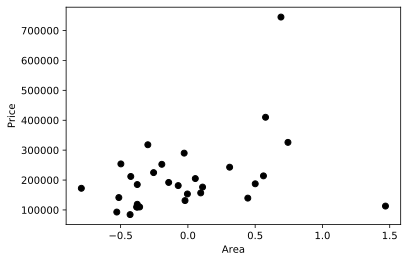

In [287]:
batch_size = 100
train_iter = get_dataloader([train_features, train_labels], batch_size)
test_iter = get_dataloader([test_features], batch_size, shuffle=False)

for X, y in train_iter:
    show_plot(X[:30, 2].asnumpy(), y[:30].asnumpy(), 'Area', 'Price')
    break

In [288]:
net = nn.Sequential()
# net.add(nn.Dense(32, activation='sigmoid'))
# net.add(nn.Dropout(0.3))
# net.add(nn.Dense(16, activation='sigmoid'))
# net.add(nn.Dropout(0.5))
net.add(nn.Dense(8, activation='sigmoid'))
net.add(nn.Dropout(0.2))
net.add(nn.Dense(1))
net.initialize(init.Xavier())

In [289]:
# loss = gluon.loss.L2Loss()
loss = logrmse
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate':0.003, 'wd': 0.01})

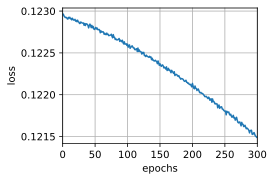

In [290]:
epochs = 300
animator = d2l.Animator('epochs', 'loss', xlim=[0, epochs])

for epoch in range(epochs):
    for X, y in train_iter:
        with autograd.record():
            result = net(X)
            l = loss(result, y)            
        l.backward()
        trainer.step(batch_size)
    epoch_loss = evaluate_loss(net, train_iter, loss)
    animator.add(epoch, epoch_loss)